In [1]:
import sys
import copy
import os
sys.path.append("/home/lauro/code/msc-thesis/svgd/kernel_learning")
import json
import collections
import itertools
from functools import partial
import importlib
from tqdm import tqdm

import numpy as onp
from jax.config import config
config.update("jax_debug_nans", True)
# config.update("jax_enable_x64", True)

import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd, value_and_grad
from jax import lax
from jax.ops import index_update, index
import matplotlib.pyplot as plt

import numpy as onp
import jax
import pandas as pd
import haiku as hk
import ot

import config

import utils
import metrics
import time
import plot
import stein
import kernels
import distributions
import variance

from jax.experimental import optimizers

key = random.PRNGKey(0)

from jax.scipy.stats import norm

/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
source = distributions.Gaussian(0, 10)

In [3]:
def mean(fun, m):
    """
    Arguments:
        fun : callable, takes a random key as first argument. returns scalar.
        m : integer (nr samples for mean)
    Returns
        mfun : takes same args as fun and returns mean of fun over m random seeds
    """
    def mfun(key, *args, **kwargs):
        keys = random.split(key, m)
        return np.mean(np.asarray([fun(k, *args, **kwargs) for k in keys]))
    return mfun

# `var_exp`
recall: this is an estimate of
$$\text{Var}_X(\text{E}_Y[h(X, Y)])$$

In [4]:
def h(x, y): return np.squeeze(x+y)
# hvv = vmap(vmap(h, (None, 0)), (0, None))

xs = source.sample(100)
gram = vmap(vmap(h, (0, None)), (None, 0))(xs, xs)

Variance should be variance of source

In [5]:
variance.var_exp(gram)

DeviceArray(8.918742, dtype=float32)

# `var_hxy`

recall: this is an estimate of
$$ \text{Var}_{XY}(h(X, Y))$$

In [6]:
xs = source.sample(1000)
def h(x, y): return np.squeeze(x+y)
gram = vmap(vmap(h, (0, None)), (None, 0))(xs, xs)

Variance should be twice the variance of source

In [7]:
variance.var_hxy(gram)

DeviceArray(20.646362, dtype=float32)

# Test variance of KSD estimators
compare U-estimator with linear time estimator

In [8]:
target = distributions.Gaussian(0, 1)
source = distributions.Gaussian(0, 10)
kernel = kernels.get_rbf_kernel_logscaled(logh=0)
m = 300

Estimate variance of KSD_U with samples

In [9]:
@partial(jit, static_argnums=1)
def ksd_u_estimator(key, n):
    samples = source.sample(n, key=key)
    ksd = stein.ksd_squared_u(samples, target.logpdf, kernel, return_variance=False)
    return ksd

@partial(jit, static_argnums=1)
def variance_estimator(key, n):
    samples = source.sample(n, key=key)
    return variance.compute_var_ksd(samples, target.logpdf, kernel)

def mc_variance(key, n):
    """Return variance computed brute-force over m samples of n particles"""
    keys = random.split(key, m)
    return np.var(np.asarray([ksd_u_estimator(subkey, n) for subkey in keys]), ddof=1)

# def mean_variance_est(key, n):
#     """Return mean variance computed using formula.
#     Mean is over m samples of n particles."""
#     keys = random.split(key, m)
#     return np.mean(np.asarray([variance_estimator(n, subkey) for subkey in keys]))
mean_variance_est = mean(variance_estimator, m)

In [10]:
ngrid = 2**onp.arange(3, 11)

variances_mc = []
variances_theory = []

for n in tqdm(ngrid):
    key, subkey = random.split(key)
    variances_mc.append(mc_variance(subkey, n))
    key, subkey = random.split(key)
    variances_theory.append(mean_variance_est(subkey, n))
    
variances_mc = np.array(variances_mc)
variances_theory = np.array(variances_theory)

100%|██████████| 8/8 [00:20<00:00,  2.55s/it]


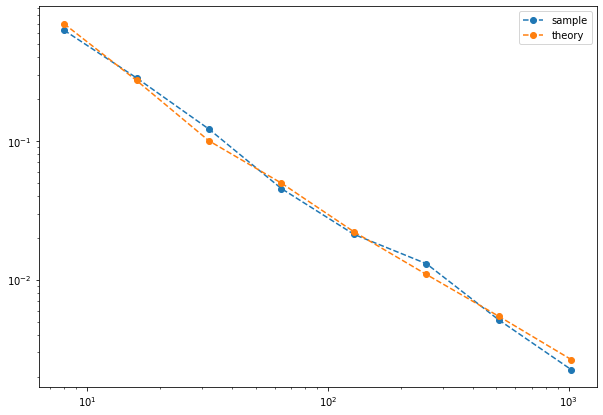

In [11]:
fig, ax = plt.subplots(figsize=[10,7])
plt.plot(ngrid, variances_mc, "--o", label="sample")
plt.plot(ngrid, variances_theory, "--o", label="theory")
plt.yscale("log")
plt.xscale("log")
plt.legend()

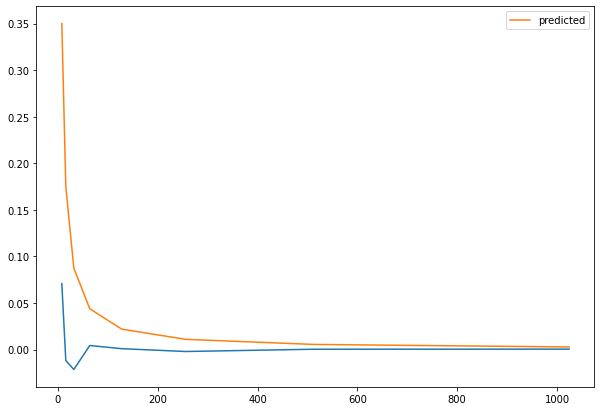

In [12]:
fig, ax = plt.subplots(figsize=[10,7])
plt.plot(ngrid, variances_theory - variances_mc)
plt.plot(ngrid, 0.7 * 4 / ngrid, label="predicted")
plt.legend()
# plt.yscale("log")
# plt.xscale("log")

In [13]:
lsdjf

NameError: name 'lsdjf' is not defined

# check subcomputations for bias

### $\text{Var}_X(\text{E}_Y[h(X, Y)])$

In [ ]:
def h(x, y):
    return stein.h(x, y, kernel, target.logpdf)
# def h(x, y): return np.squeeze(x+y)
hvv = vmap(vmap(h, (None, 0)), (0, None))

@partial(jit, static_argnums=0)
def var_exp_mc(n, key):
    key_x, key_y = random.split(key)
    def exp_hxy(y, key):
        """Return E_x[h(x, y)]"""
        xs = source.sample(n, key=key)
        return np.mean(vmap(h, (0, None))(xs, y))
    
    keys = random.split(key_x, n)
    ys = source.sample(n, key=key_y)
    return np.var(vmap(exp_hxy)(ys, keys))
    
@partial(jit, static_argnums=0)
def var_exp_quadratic(n, key):
    samples = source.sample(n, key=key)
    gram = hvv(samples, samples)
    return variance.var_exp(gram)

def mean_var_exp(n, m, key):
    """Return mean brute-force over m samples of n particles"""
    keys = random.split(key, m)
    return np.mean(vmap(var_exp_mc,       (None, 0))(n, keys))

def mean_var_exp_quadratic(n, m, key):
    """Return mean brute-force over m samples of n particles"""
    keys = random.split(key, m)
    return np.mean(vmap(var_exp_quadratic, (None, 0))(n, keys))

In [ ]:
lgrid = np.arange(100, 500, 10)
key, *subkeys = random.split(key, len(lgrid)+1)
l = [var_exp_mc(n, k) for n, k in zip(lgrid, subkeys)]

In [ ]:
plt.plot(lgrid, l)
plt.axhline(y=onp.mean(l[-20:]))

In [ ]:
m = 100
ngrid = 2**onp.arange(6, 13)

variances = []
variances_quadratic = []

for n in tqdm(ngrid):
    key, subkey = random.split(key)
    variances.append(mean_var_exp(n, m, subkey))
    key, subkey = random.split(key)
    variances_quadratic.append(mean_var_exp_quadratic(n, m, subkey))
    
variances = np.array(variances)
variances_quadratic = np.array(variances_quadratic)

In [ ]:
fig, ax = plt.subplots(figsize=[10,7])
plt.plot(ngrid, variances, "--o", label="linear")
plt.plot(ngrid, variances_quadratic, "--o", label="quadratic")
plt.yscale("log")
plt.legend()

In [ ]:
fig, ax = plt.subplots(figsize=[10,7])
plt.plot(ngrid, variances_quadratic - variances, "--o", label="Diff")
plt.legend()

### $ \text{Var}_{XY}(h(X, Y))$

In [ ]:
def h(x, y):
    return stein.h(x, y, kernel, target.logpdf)
hvv = vmap(vmap(h, (None, 0)), (0, None))

@partial(jit, static_argnums=0)
def var_hxy_mc(n, key):
    xs, ys = source.sample(2*n, key=key).split(2)
    return np.var(vmap(h)(xs, ys))
    
@partial(jit, static_argnums=0)
def var_hxy_quadratic(n, key):
    samples = source.sample(n, key=key)
    gram = hvv(samples, samples)
    return variance.var_hxy(gram)

def mean_var_hxy(n, m, key):
    """Return mean brute-force over m samples of n particles"""
    keys = random.split(key, m)
    return np.mean(vmap(var_hxy_mc, (None, 0))(n, keys))

def mean_var_hxy_quadratic(n, m, key):
    """Return mean brute-force over m samples of n particles"""
    keys = random.split(key, m)
    return np.mean(vmap(var_hxy_quadratic, (None, 0))(n, keys))

In [ ]:
m = 300
ngrid = 2**onp.arange(3, 11)

variances = []
variances_quadratic = []

for n in tqdm(ngrid):
    key, subkey = random.split(key)
    variances.append(mean_var_hxy(n, m, subkey))
    key, subkey = random.split(key)
    variances_quadratic.append(mean_var_hxy_quadratic(n, m, subkey))

fig, ax = plt.subplots(figsize=[10,7])
plt.plot(ngrid, variances, "--o", label="linear")
plt.plot(ngrid, variances_quadratic, "--o", label="quadratic")
plt.yscale("log")
plt.legend()